In [30]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation, BatchNormalization, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt


In [31]:
# path
train_path = 'D:/test2/ETT_v3/Fold1/train/'
train_annot_path = 'D:/test2/ETT_v3/Fold1/trainannot/'
val_path = 'D:/test2/ETT_v3/Fold1/val/'
val_annot_path = 'D:/test2/ETT_v3/Fold1/valannot/'
test_path = 'D:/test2/ETT_v3/Fold1/test/'
test_annot_path = 'D:/test2/ETT_v3/Fold1/testannot/'

In [32]:
def conv_block(input_tensor, num_filters):
    """构建两层的卷积块"""
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

def upsample_concat(block, bridge):
    """上采样并连接跳过连接的层"""
    up = UpSampling2D((2, 2))(block)
    return concatenate([up, bridge], axis=-1)

def unet_plus_plus(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(input_shape)

    # Encoder path
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder path with nested skip pathways
    u6 = upsample_concat(b, c4)
    c6 = conv_block(u6, 512)
    u7 = upsample_concat(c6, c3)
    c7 = conv_block(u7, 256)
    u8 = upsample_concat(c7, c2)
    c8 = conv_block(u8, 128)
    u9 = upsample_concat(c8, c1)
    c9 = conv_block(u9, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
def load_and_preprocess_image(image_path, mask_path, target_size=(256, 256)):
    # 讀取圖像和對應的標籤
    image = load_img(image_path, target_size=target_size)
    mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')
    
    # 轉換為數組並進行正規化
    image = img_to_array(image) / 255.0
    mask = img_to_array(mask) // 255  # 假設標籤圖像是黑白的，每個像素255表示標籤1
    
    return image, mask

def prepare_dataset(path, annot_path, batch_size):
    # 獲取所有圖像的路徑
    image_filenames = os.listdir(path)
    mask_filenames = os.listdir(annot_path)
    
    # 確保排序後的圖像和標籤對應
    image_filenames.sort()
    mask_filenames.sort()
    
    image_paths = [os.path.join(path, fname) for fname in image_filenames]
    mask_paths = [os.path.join(annot_path, fname) for fname in mask_filenames]
    
    # 載入和前處理所有圖像和標籤
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img, mask = load_and_preprocess_image(img_path, mask_path)
        images.append(img)
        masks.append(mask)
    
    # 將列表轉換為Numpy數組
    images = np.array(images)
    masks = np.array(masks)
    
    # 創建數據集對象
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size)
    return dataset

# 準備訓練和驗證數據集
train_dataset = prepare_dataset(train_path, train_annot_path, batch_size=8)
val_dataset = prepare_dataset(val_path, val_annot_path, batch_size=8)
test_dataset = prepare_dataset(test_path, test_annot_path, batch_size=8)

In [34]:
model = unet_plus_plus()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_63 (Conv2D)          (None, 256, 256, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 activation_58 (Activation)  (None, 256, 256, 64)         0         ['conv2d_63[0][0]']           
                                                                                                  
 batch_normalization_54 (Ba  (None, 256, 256, 64)         256       ['activation_58[0][0]']       
 tchNormalization)                                                                          

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,          
    verbose=1,           
    restore_best_weights=True
)


# 設定訓練的epochs數
epochs = 30

# 訓練資料
history = model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# 測試資料
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

Epoch 1/30
36/36 [==============================] - 500s 14s/step - loss: 1.0025 - accuracy: 0.7505 - val_loss: 0.2514 - val_accuracy: 0.9802
Epoch 2/30
36/36 [==============================] - 491s 14s/step - loss: 0.6437 - accuracy: 0.9838 - val_loss: 0.6544 - val_accuracy: 0.7911
Epoch 3/30
36/36 [==============================] - 485s 13s/step - loss: 0.3279 - accuracy: 0.9925 - val_loss: 0.1321 - val_accuracy: 0.9946
Epoch 4/30
36/36 [==============================] - 471s 13s/step - loss: 0.1518 - accuracy: 0.9934 - val_loss: 0.0886 - val_accuracy: 0.9946
Epoch 5/30
36/36 [==============================] - 474s 13s/step - loss: 0.0815 - accuracy: 0.9945 - val_loss: 0.0677 - val_accuracy: 0.9946
Epoch 6/30
36/36 [==============================] - 495s 14s/step - loss: 0.0515 - accuracy: 0.9951 - val_loss: 0.0451 - val_accuracy: 0.9946
Epoch 7/30
36/36 [==============================] - 528s 15s/step - loss: 0.0378 - accuracy: 0.9953 - val_loss: 0.0397 - val_accuracy: 0.9946
Epoch 

In [36]:
# Visualize some predictions
def plot_predictions(images, masks, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
        plt.show()

In [37]:
def calculate_iou(y_true, y_pred, num_classes):
    # y_pred 需要透過 argmax 獲取最有可能的類別
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    iou_calculator = MeanIoU(num_classes=num_classes)
    iou_calculator.update_state(y_true, y_pred)
    return iou_calculator.result().numpy()

In [38]:
def indicator_within_range(y_true, y_pred, threshold, P):
    threshold_pixels = tf.cast(P * threshold, tf.int32)  # 轉換成整數
    return tf.cast(tf.abs(y_true - y_pred) <= threshold_pixels, tf.float32)

def accuracy_within_0_5_cm(y_true, y_pred, P):
    # 確保 y_true 和 y_pred 都是 tf.int32 類型
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    K = tf.size(y_true, out_type=tf.int32)  # tf.size 的 out_type 也設定為 tf.int32
    indicator_values = indicator_within_range(y_true, y_pred, 0.5, P)
    return tf.reduce_sum(indicator_values) / tf.cast(K, tf.float32) * 100

def accuracy_within_1_cm(y_true, y_pred, P):
    # 確保 y_true 和 y_pred 都是 tf.int32 類型
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    
    K = tf.size(y_true, out_type=tf.int32)  # tf.size 的 out_type 也設定為 tf.int32
    indicator_values = indicator_within_range(y_true, y_pred, 1.0, P)
    return tf.reduce_sum(indicator_values) / tf.cast(K, tf.float32) * 100

In [39]:
def check_predictions(y_true, y_pred, num_classes):
    if tf.reduce_any(y_pred >= num_classes) or tf.reduce_any(y_pred < 0):
        raise ValueError(f"`y_pred` has invalid values. All elements must be in range [0, {num_classes-1}]")
    if tf.reduce_any(y_true >= num_classes) or tf.reduce_any(y_true < 0):
        raise ValueError(f"`y_true` has invalid values. All elements must be in range [0, {num_classes-1}]")

In [40]:
# 修改evaluate_model函數以包含精確度計算
def evaluate_model(model, dataset, num_classes, P):
    total_iou = 0
    accuracy_0_5_cm_total = 0
    accuracy_1_0_cm_total = 0
    count = 0
    for images, masks in dataset:
        predictions = model.predict(images)
        y_pred = tf.argmax(predictions, axis=-1)
        y_true = tf.cast(tf.squeeze(masks), tf.int32)


        if not tf.reduce_all(tf.less(y_true, num_classes)):
            print("y_true contains values outside [0, num_classes-1]")
        if not tf.reduce_all(tf.less(y_pred, num_classes)):
            print("y_pred contains values outside [0, num_classes-1]")

        # 檢查預測值是否有效
        check_predictions(y_true, y_pred, num_classes)
        
        iou_calculator = MeanIoU(num_classes=num_classes)
        iou_calculator.update_state(y_true, y_pred)
        iou_score = iou_calculator.result().numpy()
        total_iou += iou_score
        
        # 計算精度
        accuracy_0_5_cm_total += accuracy_within_0_5_cm(y_true, y_pred, P)
        accuracy_1_0_cm_total += accuracy_within_1_cm(y_true, y_pred, P)
        
        count += 1

    avg_iou = total_iou / count if count else 0
    avg_accuracy_0_5_cm = accuracy_0_5_cm_total / count if count else 0
    avg_accuracy_1_0_cm = accuracy_1_0_cm_total / count if count else 0
    
    return avg_iou, avg_accuracy_0_5_cm, avg_accuracy_1_0_cm

# 設定像素到公分的轉換比例
P = 72  # 每公分72像素

# 在訓練資料集上評估模型
train_iou, train_accuracy_0_5_cm, train_accuracy_1_0_cm = evaluate_model(model, train_dataset, num_classes=2, P=P)
print(f"Training Data: Average IOU: {train_iou}")
print(f"Training Data: Average Accuracy within 0.5 cm: {train_accuracy_0_5_cm}")
print(f"Training Data: Average Accuracy within 1.0 cm: {train_accuracy_1_0_cm}")

1/1 [==============================] - 2s 2s/step
Training Data: Average IOU: 0.9223701788319482
Training Data: Average Accuracy within 0.5 cm: 100.0
Training Data: Average Accuracy within 1.0 cm: 100.0


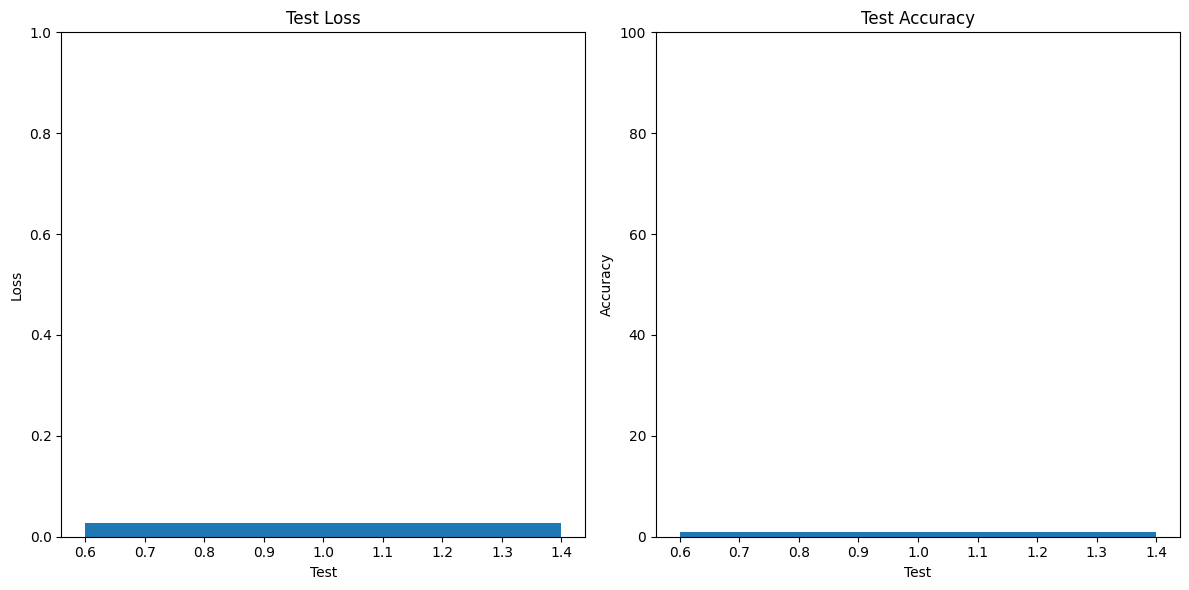

In [41]:
def plot_test_results(test_loss, test_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].bar(1, test_loss)
    ax[0].set_title('Test Loss')
    ax[0].set_xlabel('Test')
    ax[0].set_ylabel('Loss')
    ax[0].set_ylim([0, max(test_loss * 1.1, 1)])

    ax[1].bar(1, test_accuracy)
    ax[1].set_title('Test Accuracy')
    ax[1].set_xlabel('Test')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim([0, 100])

    plt.tight_layout()
    plt.show()

plot_test_results(test_loss, test_accuracy)

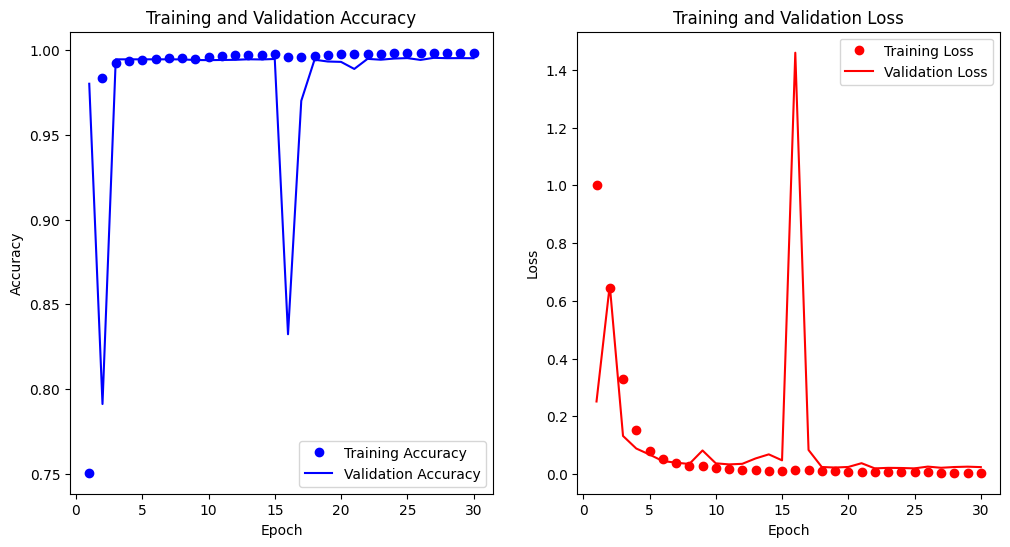

1/1 [==============================] - 2s 2s/step


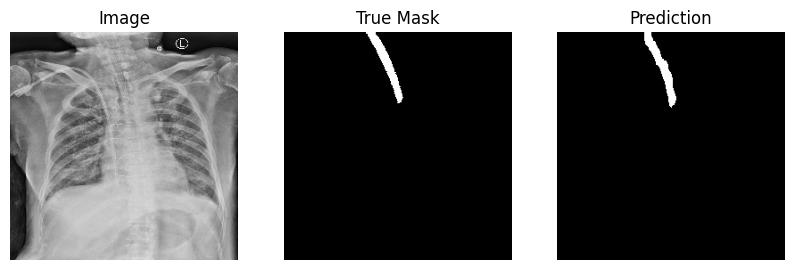

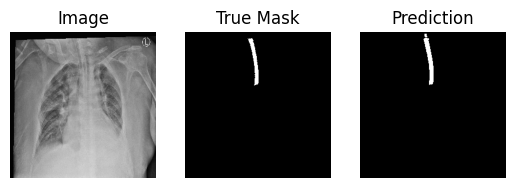

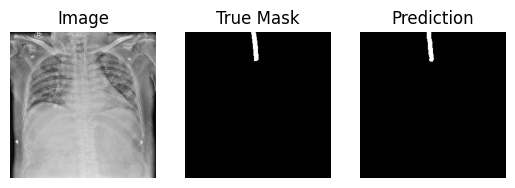

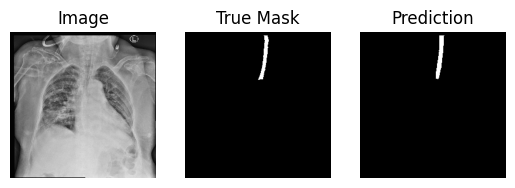

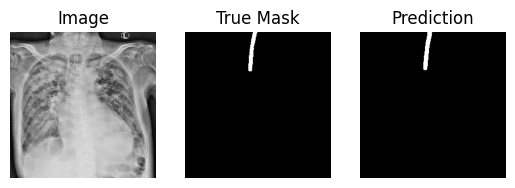

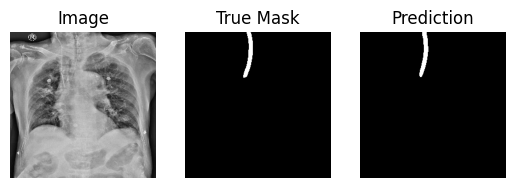

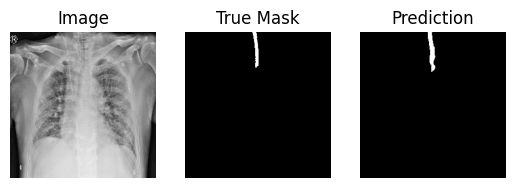

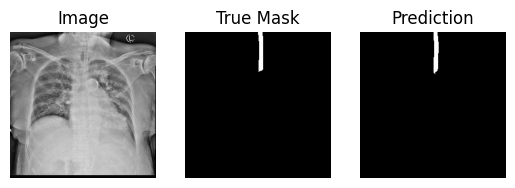

In [42]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)
for images, masks in train_dataset.take(1):
    predictions = model.predict(images)
    predictions = tf.argmax(predictions, axis=-1)
    predictions = predictions[..., tf.newaxis]
    plot_predictions(images.numpy(), masks.numpy(), predictions.numpy()) 

Test Loss: 0.027266401797533035
Test Accuracy: 99.52444434165955%


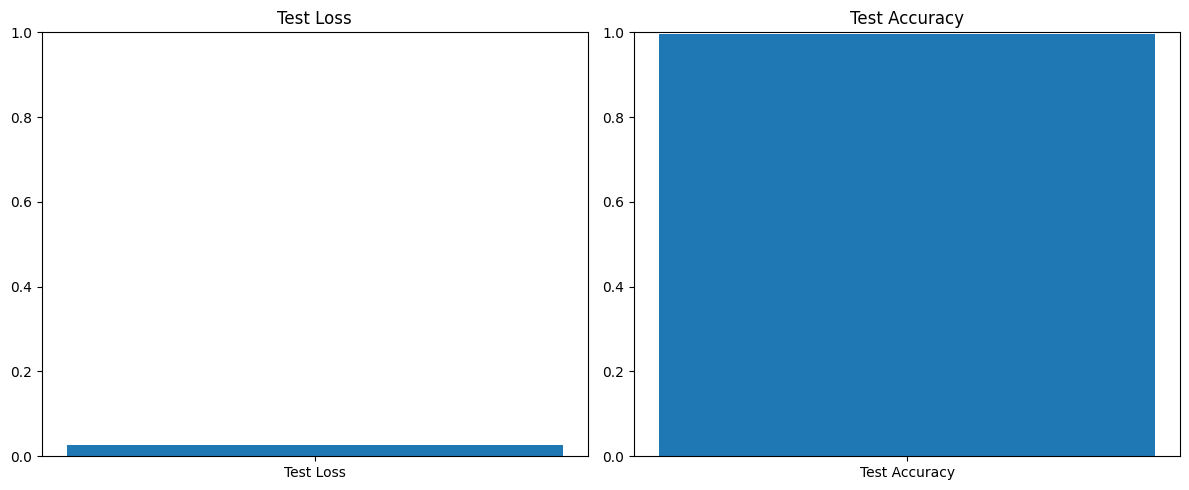

In [43]:
def display_test_results(test_loss, test_accuracy):
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy * 100}%")

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].bar(['Test Loss'], [test_loss])
    ax[0].set_title('Test Loss')
    ax[0].set_ylim([0, max(test_loss * 1.2, 1)])

    ax[1].bar(['Test Accuracy'], [test_accuracy])
    ax[1].set_title('Test Accuracy')
    ax[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


display_test_results(test_loss, test_accuracy)